In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2018 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer Learning with TensorFlow Hub for TFLite

## Setup 

In [4]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Using TensorFlow Version: 2.12.0
• Using TensorFlow Hub Version:  0.13.0
• GPU Device Found.


## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [6]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` only has one defined split, `train`, we are going to divide that into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [7]:
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', 
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [8]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

Now shuffle and batch the data


In [9]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [10]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect a batch

In [11]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [12]:
do_fine_tuning = False #@param {type:"boolean"}

Load TFHub Module

In [13]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [14]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## Training the Model

In [16]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 53s 63ms/step - loss: 0.0511 - accuracy: 0.9836 - val_loss: 0.0426 - val_accuracy: 0.9832
Epoch 2/5
582/582 [==============================] - 42s 65ms/step - loss: 0.0297 - accuracy: 0.9899 - val_loss: 0.0356 - val_accuracy: 0.9871
Epoch 3/5
582/582 [==============================] - 38s 56ms/step - loss: 0.0244 - accuracy: 0.9920 - val_loss: 0.0345 - val_accuracy: 0.9905
Epoch 4/5
582/582 [==============================] - 40s 61ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 0.0360 - val_accuracy: 0.9893
Epoch 5/5
582/582 [==============================] - 39s 59ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0388 - val_accuracy: 0.9901


## Export the Model

In [18]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

Export the SavedModel

In [19]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

In [20]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-05-08 09:14:07.715837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [22]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


## Convert Using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

### Post-Training Quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [24]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-Training Integer Quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [25]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [26]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full Integer Quantization

To require the converter to only output integer operations, one can specify:

In [27]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [28]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [29]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [30]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:00<00:00, 28.83it/s]


In [31]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite doesn't have super optimized server CPU kernels. For this reason post-training full-integer quantized models  may be slower here than the other kinds of optimized models. But for mobile CPUs, considerable speedup can be observed.

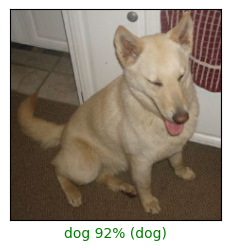

In [40]:
#@title Visualize the outputs { run: "auto" }
index = 1 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Create a file to save the labels.

In [33]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

If you are running this notebook in a Colab, you can run the cell below to download the model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [34]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prepare the Test Images for Download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [35]:
!mkdir -p test_images

In [36]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [37]:
!ls test_images

cat_0.jpg   cat_21.jpg	cat_32.jpg  cat_45.jpg	dog_13.jpg  dog_41.jpg
cat_11.jpg  cat_22.jpg	cat_34.jpg  cat_46.jpg	dog_17.jpg  dog_44.jpg
cat_12.jpg  cat_23.jpg	cat_35.jpg  cat_47.jpg	dog_1.jpg   dog_48.jpg
cat_14.jpg  cat_24.jpg	cat_36.jpg  cat_4.jpg	dog_27.jpg  dog_49.jpg
cat_15.jpg  cat_25.jpg	cat_39.jpg  cat_5.jpg	dog_29.jpg  dog_6.jpg
cat_16.jpg  cat_26.jpg	cat_3.jpg   cat_7.jpg	dog_2.jpg
cat_18.jpg  cat_28.jpg	cat_40.jpg  cat_8.jpg	dog_33.jpg
cat_19.jpg  cat_30.jpg	cat_42.jpg  cat_9.jpg	dog_37.jpg
cat_20.jpg  cat_31.jpg	cat_43.jpg  dog_10.jpg	dog_38.jpg


In [38]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [39]:
try:
    files.download('cats_vs_dogs_test_images.zip')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>